In [ ]:
import re, torch, random, requests
import numpy as np, matplotlib.pyplot as plt
from torch import nn
from collections import Counter
from sklearn.manifold import TSNE

device = 'cuda' if torch.cuda.is_available() else 'cpu'
context = 5; embed_dim = 64; hidden = 1024; epochs = 1000; bs = 64
print("Using:", device)


Using: cuda


In [ ]:
urls = [
    'https://www.gutenberg.org/files/1661/1661-0.txt', #(Sherlock Holmes)
    # 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt', #(Shakespeare)
    # 'https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt', # (War and Peace)
    # 'https://www.gutenberg.org/files/1342/1342-0.txt' #(Pride and Prejudice)
    ]

all_texts = []
print("Fetching data from all sources...")

for url in urls:
    try:
        response = requests.get(url)
        response.raise_for_status()
        all_texts.append(response.text)
        print(f"Successfully fetched {url.split('/')[-1]}")
    except requests.exceptions.RequestException as e:
        print(f"Warning: Could not fetch {url}. Error: {e}")


text = "\n".join(all_texts).lower()

print(f"All texts combined. Total characters: {len(text)}")
lines = [re.sub('[^a-z0-9 \.]', '', l) for l in text.split('\n')]
tokens = [w for l in lines for w in l.split() if w]
print(f"Total tokens: {len(tokens)}")

Fetching data from all sources...
Successfully fetched 1661-0.txt
All texts combined. Total characters: 593731
Total tokens: 107510


In [ ]:
freq = Counter(tokens)
vocab = sorted(freq.keys())
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}
print("Vocab size:", len(vocab))
print("Top 10:", freq.most_common(10))
print("Bottom 10:", freq.most_common()[-10:])

Vocab size: 10489
Top 10: [('the', 5811), ('and', 3066), ('i', 2966), ('of', 2774), ('to', 2753), ('a', 2679), ('in', 1805), ('that', 1727), ('it', 1561), ('you', 1452)]
Bottom 10: [('network', 1), ('support.', 1), ('included.', 1), ('necessarily', 1), ('edition.', 1), ('pg', 1), ('includes', 1), ('subscribe', 1), ('newsletter', 1), ('ebooks.', 1)]


In [ ]:
X, Y = [], []
for i in range(len(tokens)-context):
    X.append([stoi[w] for w in tokens[i:i+context]])
    Y.append(stoi[tokens[i+context]])
X, Y = torch.tensor(X), torch.tensor(Y)
n = int(0.9*len(X))
train_x, val_x = X[:n], X[n:]
train_y, val_y = Y[:n], Y[n:]
print("Train size:", len(train_x))

Train size: 96754


In [ ]:
# class MLP(nn.Module):
#     def __init__(self, vocab, embed, hidden, ctx):
#         super().__init__()
#         self.e = nn.Embedding(vocab, embed)
#         self.fc1 = nn.Linear(embed*ctx, hidden)
#         self.fc2 = nn.Linear(hidden, vocab)
#     def forward(self, x):
#         x = self.e(x).view(x.size(0), -1)
#         return self.fc2(torch.relu(self.fc1(x)))

# model = MLP(len(vocab), embed_dim, hidden, context).to(device)
# opt = torch.optim.Adam(model.parameters(), 1e-3)
# loss_fn = nn.CrossEntropyLoss()

class MLP(nn.Module):
    def __init__(self, vocab, embed, hidden, ctx):
        super().__init__()
        self.e = nn.Embedding(vocab, embed)
        self.fc1 = nn.Linear(embed * ctx, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, vocab)

    def forward(self, x):
        x = self.e(x).view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = MLP(len(vocab), embed_dim, hidden, context).to(device)
opt = torch.optim.Adam(model.parameters(), 1e-3)
loss_fn = nn.CrossEntropyLoss()


Epoch 100: train=6.763 val=7.217
Epoch 200: train=6.990 val=6.959
Epoch 300: train=7.030 val=7.032
Epoch 400: train=6.562 val=6.870
Epoch 500: train=5.743 val=6.783
Epoch 600: train=6.268 val=6.865
Epoch 700: train=6.033 val=6.684
Epoch 800: train=6.353 val=6.953
Epoch 900: train=6.239 val=6.690
Epoch 1000: train=5.623 val=6.894


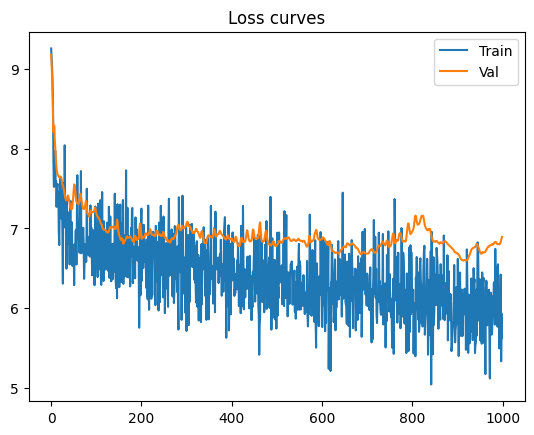

In [ ]:
train_losses, val_losses = [], []
for e in range(epochs):
    model.train()
    idx = torch.randperm(len(train_x))
    xb, yb = train_x[idx][:bs].to(device), train_y[idx][:bs].to(device)
    opt.zero_grad()
    loss = loss_fn(model(xb), yb)
    loss.backward(); opt.step()

    # Validation
    model.eval()
    with torch.no_grad():
        vloss = loss_fn(model(val_x[:bs].to(device)), val_y[:bs].to(device))
    train_losses.append(loss.item()); val_losses.append(vloss.item())

    if (e+1)%100==0:
        print(f"Epoch {e+1}: train={loss.item():.3f} val={vloss.item():.3f}")

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend(); plt.title("Loss curves"); plt.show()

In [ ]:
import torch.nn.functional as F

def generate(seed="the detective said", n=20, temp=1.0):
    model.eval()
    words = seed.lower().split()
    for _ in range(n):
        ctx = words[-context:]
        if len(ctx) < context: ctx = ['.']*(context-len(ctx)) + ctx
        x = torch.tensor([[stoi.get(w,0) for w in ctx]]).to(device)
        logits = model(x) / temp
        next_idx = torch.multinomial(F.softmax(logits, -1), 1).item()
        words.append(itos[next_idx])
    return ' '.join(words)

print(generate("the detective said", 15, 1.0))

the detective said that will holmes a understand. had never no once a back his piled last her


In [ ]:
print("  Seed: 'it was a dark and' ->")
print("   ", generate("it was a dark and", 30, temp=0.9))
print("  Seed: 'to be or not to' ->")
print("   ", generate("to be or not to", 30, temp=1.0))
print("  Seed: 'the detective said' ->")
print("   ", generate("the detective said", 30, temp=0.8))

  Seed: 'it was a dark and' ->
    it was a dark and for the staggered seemed and be waiting. they sign the meshes and the colour. i table. no for have no no then i think to one drawn in another likely
  Seed: 'to be or not to' ->
    to be or not to upon my laws. turn to to go in a of memory. no himself the singular road she had i were watson were with only right the case and a there
  Seed: 'the detective said' ->
    the detective said a how as to europe but he came the over the more of it will have half carried a violet as the mouth a viii. to the are in the


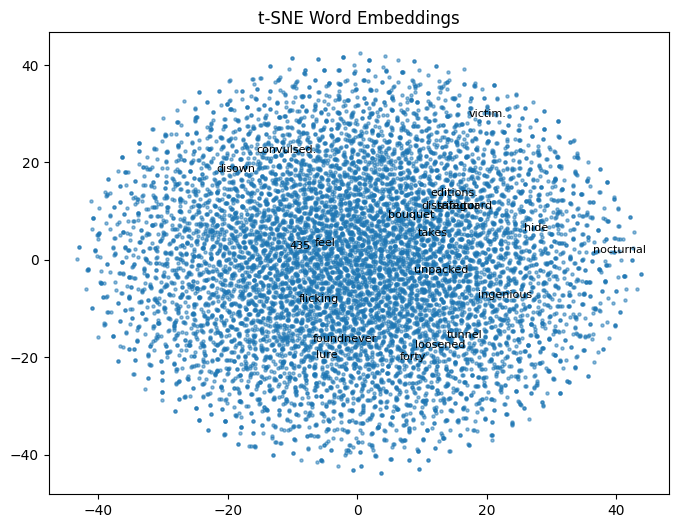

In [ ]:
emb = model.e.weight.detach().cpu().numpy()
emb2 = TSNE(n_components=2, random_state=42).fit_transform(emb)
plt.figure(figsize=(8,6))
plt.scatter(emb2[:,0], emb2[:,1], s=5, alpha=0.5)
plt.title("t-SNE Word Embeddings")
for w in random.sample(list(stoi.keys()), 20):
    i = stoi[w]; plt.text(emb2[i,0], emb2[i,1], w, fontsize=8)
plt.show()

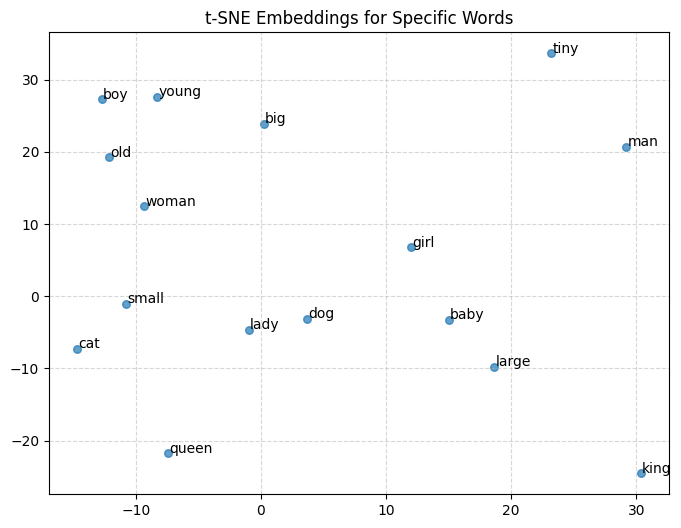

In [ ]:
emb = model.e.weight.detach().cpu().numpy()
emb2 = TSNE(n_components=2, random_state=42).fit_transform(emb)
# List of specific words
target_words = ["king", "queen", "man", "woman", "cat", "dog", "puppy", "baby","boy","girl","lady","young","old","kitten","large","big","small","tiny"]

# 2D coordinates and labels for these words
points = []
labels = []
for w in target_words:
    if w in stoi:
        i = stoi[w]
        points.append(emb2[i]) # 2D coordinate from the full t-SNE
        labels.append(w)
    else:
        print(f"Warning: '{w}' not in vocab, cannot plot.")

points = np.array(points)
plt.figure(figsize=(8, 6))

if len(points) > 0:
    plt.scatter(points[:, 0], points[:, 1], s=30, alpha=0.7)
    for (x, y), label in zip(points, labels):
        plt.text(x + 0.1, y + 0.1, label, fontsize=10)

    plt.title("t-SNE Embeddings for Specific Words")
    plt.grid(True, linestyle='--', alpha=0.5)
else:
    plt.title("None of the target words were found in the vocabulary.")

plt.show()

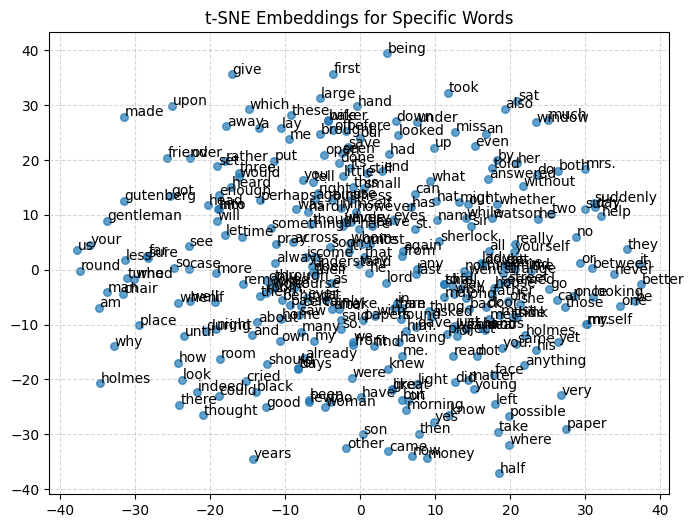

In [ ]:
# Take the top 300 tokens
emb = model.e.weight.detach().cpu().numpy()
emb2 = TSNE(n_components=2, random_state=42).fit_transform(emb)

sorted_tokens = sorted(freq.items(), key=lambda x: x[1], reverse=True)
top_300 = [tok for tok, count in sorted_tokens[:300]]
target_words = top_300

points = []
labels = []
for w in target_words:
    if w in stoi:
        i = stoi[w]
        points.append(emb2[i])
        labels.append(w)
    else:
        print(f"Warning: '{w}' not in vocab, cannot plot.")

points = np.array(points)
plt.figure(figsize=(8, 6))

if len(points) > 0:
    plt.scatter(points[:, 0], points[:, 1], s=30, alpha=0.7)
    for (x, y), label in zip(points, labels):
        plt.text(x + 0.1, y + 0.1, label, fontsize=10)

    plt.title("t-SNE Embeddings for Specific Words")
    plt.grid(True, linestyle='--', alpha=0.5)
else:
    plt.title("None of the target words were found in the vocabulary.")

plt.show()